Notebook used to inspect results of Granger Causality analysis

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import math
import sys
import re
from itertools import combinations
from matplotlib_venn import venn3

# Get the project root: notebooks/AI_narrative_index
root_dir = Path.cwd().parent

# Add needed folders to the Python modules search path
sys.path.append(str(root_dir / "src" / "scripts"))
sys.path.append(str(root_dir / "src" / "visualizations"))
sys.path.append(str(root_dir / "src" / "modelling"))

# import custom functions
#rom plot_granger_causality import plot_aini_lags_by_year, plot_aini_lags_for_year
from plot_functions import plot_n_articles_with_extrema_events, plot_stock_growth
from construct_tables import export_regression_table 
#from compute_rejections import compute_rejection_rates_all, add_trading_days_columns, export_rejection_rates_to_pptx_all_tables_only


No control

In [114]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results["joint rej. (α=0.1)"] = gc_all_results["BH_reject_F"] & gc_all_results["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results = gc_all_results.rename(columns=rename_map)
gc_all_results




# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report = gc_all_results[(gc_all_results["Model"] == "custom") | (gc_all_results["Period"] != "2025")]
gc_all_results_for_report  = gc_all_results_for_report[~((gc_all_results_for_report["AINI_variant"] == "EMA_02") & (gc_all_results_for_report["Period"] == "2025"))]

print(len(gc_all_results_for_report) / 2)

3735.0


In [115]:
gc_all_results_for_report_a2r = gc_all_results_for_report[gc_all_results_for_report["Direction"] == "AINI_to_RET"]
gc_all_results_for_report_a2r = gc_all_results_for_report_a2r.dropna(axis=1, how='all')

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report_a2r

,Ticker,AINI_variant,Period,Direction,β₀,β_x1_ar,β_x1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β_x2_ar,β_x2,β_x3_ar,β_x3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078011,0.004486,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077520,0.000454,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077651,0.001204,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
6,AAPL,normalized_AINI_z,2023,AINI_to_RET,0.000765,0.077651,0.000096,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102461,-0.016991,1,186,10000,...,False,0.558944,False,0.542211,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8630,TSLA,normalized_AINI_z,2024_25,AINI_to_RET,-0.000175,-0.013054,0.001448,3,344,10000,...,False,0.636636,False,0.588833,-0.007135,-0.002861,-0.019455,0.002063,w2,False
8632,TSM,EMA_02,2024_25,AINI_to_RET,0.001792,-0.091726,0.046685,3,344,10000,...,True,0.018398,True,0.004825,0.014721,-0.500252,-0.090420,0.420112,w2,True
8634,TSM,EMA_08,2024_25,AINI_to_RET,0.001745,-0.095107,0.020650,3,344,10000,...,True,0.026697,True,0.009682,0.011939,-0.102300,-0.094442,0.027328,w2,True
8636,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001752,-0.096612,0.019195,3,344,10000,...,True,0.026697,True,0.009682,0.011079,-0.076882,-0.093863,0.003450,w2,True


In [116]:
# HTML output
export_regression_table(
    df=gc_all_results_for_report_a2r,
    title="Granger-Causality all Results (AINI → Returns)",
    output_filename="gc_sp500_aini_to_ret",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret.html')

In [117]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_for_report_a2r["Period"] = gc_all_results_for_report_a2r["Period"].astype(str)
gc_all_results_for_report_a2r["Ticker"] = gc_all_results_for_report_a2r["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_for_report_a2r["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_for_report_a2r["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 3735
Both-method rejections: 203
Rejection rate: 5.44%


Controlled for sox

In [118]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_binary.csv")
gc_w0_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w0.csv")
gc_w1_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w1.csv")
gc_w2_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w2.csv")


# create column to indicate version
gc_c_sox["Model"] = "custom"
gc_w0_sox["Model"] = "w0"
gc_w1_sox["Model"] = "w1"
gc_w2_sox["Model"] = "w2"

# merge them together
gc_all_results_sox = pd.concat([gc_c_sox, gc_w0_sox, gc_w1_sox, gc_w2_sox], ignore_index=True)
gc_all_results_sox["joint rej. (α=0.1)"] = gc_all_results_sox["BH_reject_F"] & gc_all_results_sox["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results_sox = gc_all_results_sox.rename(columns=rename_map)
gc_all_results_sox

gc_all_results_for_report_sox = gc_all_results_sox.copy()
gc_all_results_for_report_sox
# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report_sox = gc_all_results_for_report_sox[(gc_all_results_for_report_sox["Model"] == "custom") | (gc_all_results_for_report_sox["Period"] != "2025")]
gc_all_results_for_report_sox  = gc_all_results_for_report_sox[~((gc_all_results_for_report_sox["AINI_variant"] == "EMA_02") & (gc_all_results_for_report_sox["Period"] == "2025"))]

print(len(gc_all_results_for_report_sox) / 2)
gc_c_sox

3129.0


,Ticker,AINI_variant,Year,Direction,β₀,A2R_beta_ret_1,A2R_beta_x_1,p_x,N_obs,N_boot,...,BH_corr_F_pval_HC3,A2R_beta_ret_2,A2R_beta_x_2,R2A_beta_x_2,R2A_beta_ret_2,A2R_beta_ret_3,A2R_beta_x_3,R2A_beta_x_3,R2A_beta_ret_3,Model
0,^SOX,EMA_02,2023,AINI_to_RET,-0.001458,0.024185,-0.039641,1,186,10000,...,0.311269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
1,^SOX,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,0.470866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
2,^SOX,EMA_08,2023,AINI_to_RET,-0.001489,0.031285,-0.038778,1,186,10000,...,0.126649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
3,^SOX,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,0.470866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
4,^SOX,normalized_AINI,2023,AINI_to_RET,-0.000902,0.035978,-0.030902,1,186,10000,...,0.126649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,^SOX,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,3,342,10000,...,0.000354,NaN,NaN,-0.04423,-0.000219,NaN,NaN,0.158459,0.320252,custom
140,^SOX,normalized_AINI,2024_25,AINI_to_RET,0.000557,-0.131754,-0.006233,3,344,10000,...,0.656905,0.058185,-0.017887,NaN,NaN,-0.076059,0.029011,NaN,NaN,custom
141,^SOX,normalized_AINI,2024_25,RET_to_AINI,NaN,NaN,NaN,3,342,10000,...,0.000793,NaN,NaN,0.01695,0.028449,NaN,NaN,0.166068,0.358735,custom
142,^SOX,normalized_AINI_z,2024_25,AINI_to_RET,0.000121,-0.131754,-0.000378,3,344,10000,...,0.656905,0.058185,-0.001085,NaN,NaN,-0.076059,0.001760,NaN,NaN,custom


In [119]:
cols = ["AINI_variant", "Ticker", "Period", "Model"]

# ensure string dtype for merge keys
for c in cols:
    gc_all_results[c] = gc_all_results[c].astype(str)
    gc_all_results_sox[c] = gc_all_results_sox[c].astype(str)

# ensure subset of relevant columns exists in both DataFrames
missing_rows = gc_all_results.merge(
    gc_all_results_sox[cols],
    on=cols,
    how="left",
    indicator=True
).query('_merge == "left_only"') \
 .drop(columns="_merge")

# display or save
print(missing_rows)

     Ticker       AINI_variant   Period    Direction        β₀   β_x1_ar  \
0      AAPL             EMA_02     2023  AINI_to_RET  0.001099  0.078011   
1      AAPL             EMA_02     2023  RET_to_AINI       NaN       NaN   
2      AAPL             EMA_08     2023  AINI_to_RET  0.000800  0.077520   
3      AAPL             EMA_08     2023  RET_to_AINI       NaN       NaN   
4      AAPL    normalized_AINI     2023  AINI_to_RET  0.000858  0.077651   
...     ...                ...      ...          ...       ...       ...   
2155    TSM             EMA_08  2024_25  RET_to_AINI       NaN       NaN   
2156    TSM    normalized_AINI  2024_25  AINI_to_RET  0.002567 -0.095238   
2157    TSM    normalized_AINI  2024_25  RET_to_AINI       NaN       NaN   
2158    TSM  normalized_AINI_z  2024_25  AINI_to_RET  0.001882 -0.095238   
2159    TSM  normalized_AINI_z  2024_25  RET_to_AINI       NaN       NaN   

          β_x1  Lags  N_obs  N_boot  ...   β_x2_ar      β_x2  β_x2_ar.1  \
0     0.0044

In [120]:
gc_all_results_for_report_a2r_sox = gc_all_results_for_report_sox[gc_all_results_for_report_sox["Direction"] == "AINI_to_RET"]
gc_all_results_for_report_a2r_sox = gc_all_results_for_report_a2r_sox.dropna(axis=1, how='all')
gc_all_results_for_report_a2r_sox

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,γ2,β3,γ3,Model,joint rej. (α=0.1)
0,^SOX,EMA_02,2023,AINI_to_RET,-0.001458,0.024185,-0.039641,1,186,10000,...,False,0.335466,False,0.311269,NaN,NaN,NaN,NaN,custom,False
2,^SOX,EMA_08,2023,AINI_to_RET,-0.001489,0.031285,-0.038778,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
4,^SOX,normalized_AINI,2023,AINI_to_RET,-0.000902,0.035978,-0.030902,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
6,^SOX,normalized_AINI_z,2023,AINI_to_RET,0.001486,0.035978,-0.002455,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
8,^SOX,EMA_02,2024,AINI_to_RET,0.000943,-0.087445,0.000307,1,251,10000,...,False,0.996900,False,0.996098,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,^GSPC,normalized_AINI_z,2024_25,AINI_to_RET,0.000437,-0.071388,0.000834,3,344,10000,...,False,0.399460,False,0.339153,0.052598,-0.000758,-0.125746,-0.000608,w2,False
7480,^SOX,EMA_02,2024_25,AINI_to_RET,0.000099,-0.129900,0.074224,3,344,10000,...,False,0.145585,True,0.099699,0.067598,-0.402648,-0.071375,0.308009,w2,False
7482,^SOX,EMA_08,2024_25,AINI_to_RET,0.000045,-0.138077,0.034249,3,344,10000,...,False,0.179882,False,0.145434,0.063374,-0.066762,-0.072517,-0.003600,w2,False
7484,^SOX,normalized_AINI,2024_25,AINI_to_RET,0.000045,-0.140611,0.029963,3,344,10000,...,False,0.179882,False,0.145434,0.063083,-0.046139,-0.070812,-0.021563,w2,False


In [121]:
# HTML output
export_regression_table(
    df=gc_all_results_for_report_a2r_sox,
    title="Granger-Causality all Results (AINI → Returns, controlled for PHLX Index)",
    output_filename="gc_sp500_aini_to_ret_PHLX",
    output_format="html"
)
gc_all_results_for_report_a2r_sox

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,γ2,β3,γ3,Model,joint rej. (α=0.1)
0,^SOX,EMA_02,2023,AINI_to_RET,-0.001458,0.024185,-0.039641,1,186,10000,...,False,0.335466,False,0.311269,NaN,NaN,NaN,NaN,custom,False
2,^SOX,EMA_08,2023,AINI_to_RET,-0.001489,0.031285,-0.038778,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
4,^SOX,normalized_AINI,2023,AINI_to_RET,-0.000902,0.035978,-0.030902,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
6,^SOX,normalized_AINI_z,2023,AINI_to_RET,0.001486,0.035978,-0.002455,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
8,^SOX,EMA_02,2024,AINI_to_RET,0.000943,-0.087445,0.000307,1,251,10000,...,False,0.996900,False,0.996098,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,^GSPC,normalized_AINI_z,2024_25,AINI_to_RET,0.000437,-0.071388,0.000834,3,344,10000,...,False,0.399460,False,0.339153,0.052598,-0.000758,-0.125746,-0.000608,w2,False
7480,^SOX,EMA_02,2024_25,AINI_to_RET,0.000099,-0.129900,0.074224,3,344,10000,...,False,0.145585,True,0.099699,0.067598,-0.402648,-0.071375,0.308009,w2,False
7482,^SOX,EMA_08,2024_25,AINI_to_RET,0.000045,-0.138077,0.034249,3,344,10000,...,False,0.179882,False,0.145434,0.063374,-0.066762,-0.072517,-0.003600,w2,False
7484,^SOX,normalized_AINI,2024_25,AINI_to_RET,0.000045,-0.140611,0.029963,3,344,10000,...,False,0.179882,False,0.145434,0.063083,-0.046139,-0.070812,-0.021563,w2,False


In [122]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_for_report_a2r_sox["Period"] = gc_all_results_for_report_a2r_sox["Period"].astype(str)
gc_all_results_for_report_a2r_sox["Ticker"] = gc_all_results_for_report_a2r_sox["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_for_report_a2r_sox["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_for_report_a2r_sox["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 3129
Both-method rejections: 200
Rejection rate: 6.39%


Controlled for S&P 500

In [123]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_log_growth_sp500_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results["joint rej. (α=0.1)"] = gc_all_results["BH_reject_F"] & gc_all_results["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results_sp500 = gc_all_results.rename(columns=rename_map)
gc_all_results_sp500

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_sp500 = gc_all_results_sp500[(gc_all_results_sp500["Model"] == "custom") | (gc_all_results_sp500["Period"] != "2025")]
gc_all_results_sp500  = gc_all_results_sp500[~((gc_all_results_sp500["AINI_variant"] == "EMA_02") & (gc_all_results_sp500["Period"] == "2025"))]

gc_all_results_sp500_for_report = gc_all_results_sp500.copy()

print(len(gc_all_results_sp500_for_report) / 2)

3735.0


In [124]:
gc_all_results_sp500_for_report_a2r = gc_all_results_sp500_for_report[gc_all_results_sp500_for_report["Direction"] == "AINI_to_RET"]
gc_all_results_sp500_for_report_a2r = gc_all_results_sp500_for_report_a2r.dropna(axis=1, how='all')
gc_all_results_sp500_for_report_a2r

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,γ2,β3,γ3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078013,0.004486,1,186,10000,...,False,0.973303,False,0.973851,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077522,0.000454,1,186,10000,...,False,0.973303,False,0.973851,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077652,0.001204,1,186,10000,...,False,0.973303,False,0.973851,NaN,NaN,NaN,NaN,custom,False
6,AAPL,normalized_AINI_z,2023,AINI_to_RET,0.000765,0.077652,0.000096,1,186,10000,...,False,0.973303,False,0.973851,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102462,-0.016991,1,186,10000,...,False,0.556144,False,0.542212,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8630,TSLA,normalized_AINI_z,2024_25,AINI_to_RET,-0.000175,-0.013054,0.001448,3,344,10000,...,False,0.635836,False,0.588833,-0.007135,-0.002861,-0.019455,0.002063,w2,False
8632,TSM,EMA_02,2024_25,AINI_to_RET,0.001792,-0.091726,0.046685,3,344,10000,...,True,0.022798,True,0.004825,0.014721,-0.500253,-0.090419,0.420112,w2,True
8634,TSM,EMA_08,2024_25,AINI_to_RET,0.001745,-0.095107,0.020650,3,344,10000,...,True,0.028697,True,0.009682,0.011939,-0.102300,-0.094442,0.027328,w2,True
8636,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001752,-0.096613,0.019195,3,344,10000,...,True,0.028697,True,0.009682,0.011079,-0.076882,-0.093863,0.003450,w2,True


In [125]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_sp500_for_report_a2r["Period"] = gc_all_results_sp500_for_report_a2r["Period"].astype(str)
gc_all_results_sp500_for_report_a2r["Ticker"] = gc_all_results_sp500_for_report_a2r["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")


Total models: 3735
Both-method rejections: 199
Rejection rate: 5.33%


In [126]:
# HTML output
export_regression_table(
    df=gc_all_results_sp500_for_report_a2r,
    title="Granger-Causality all Results (AINI → Returns, controlled for S&P500)",
    output_filename="gc_sp500_aini_to_ret",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret.html')

In [127]:
# save merged results
gc_all_results_sp500.to_csv(var_path / "granger_causality_all_SP500.csv", index=False)

# define table path
table_path = root_dir / "reports" / "tables"

# Export as HTML for online appendix
gc_all_results.to_html(table_path / "granger_causality_SP500.html", index=False)
gc_all_results

,Ticker,AINI_variant,Year,Direction,β₀,A2R_beta_ret_1,A2R_beta_x_1,p_x,N_obs,N_boot,...,A2R_beta_ret_2,A2R_beta_x_2,R2A_beta_x_2,R2A_beta_ret_2,A2R_beta_ret_3,A2R_beta_x_3,R2A_beta_x_3,R2A_beta_ret_3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078013,0.004486,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
1,AAPL,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077522,0.000454,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
3,AAPL,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077652,0.001204,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,TSM,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,3,342,10000,...,NaN,NaN,0.174410,-0.086047,NaN,NaN,0.143572,-0.022937,w2,False
8636,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001752,-0.096613,0.019195,3,344,10000,...,0.011079,-0.076882,NaN,NaN,-0.093863,0.00345,NaN,NaN,w2,True
8637,TSM,normalized_AINI,2024_25,RET_to_AINI,NaN,NaN,NaN,3,342,10000,...,NaN,NaN,0.226538,-0.124392,NaN,NaN,0.134248,-0.044154,w2,False
8638,TSM,normalized_AINI_z,2024_25,AINI_to_RET,0.001841,-0.096613,0.001001,3,344,10000,...,0.011079,-0.004009,NaN,NaN,-0.093863,0.00018,NaN,NaN,w2,True


In [128]:
# subset by direction
sp500_aini_to_ret = gc_all_results_sp500[gc_all_results_sp500["Direction"] == "AINI_to_RET"]
sp500_ret_to_aini = gc_all_results_sp500[gc_all_results_sp500["Direction"] == "RET_to_AINI"]

# cols to keep
keep_a2r = [
    "Model", "AINI_variant","adj_r2_u", "Ticker", "Period", "Lags",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

keep_r2a = [
    "Model", "AINI_variant","adj_r2_u", "Ticker", "Period", "Lags",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

# subset
sp500_aini_to_ret_sub = sp500_aini_to_ret[keep_a2r]
sp500_ret_to_aini_sub = sp500_ret_to_aini[keep_r2a]

sp500_aini_to_ret.columns

Index(['Ticker', 'AINI_variant', 'Period', 'Direction', 'β₀', 'β1', 'γ1',
       'Lags', 'N_obs', 'N_boot', 'N_boot_valid', 'F_stat', 'df_num', 'df_den',
       'Original_F_pval', 'Empirical_F_pval', 'r2_u', 'adj_r2_u', 'β₀.1', 'γ1',
       'β1', 'BH_reject_F', 'BH empirical p', 'BH_reject_F_HC3',
       'BH analytical p', 'β2', 'γ2', 'γ2', 'β2', 'β3', 'γ3', 'γ3', 'β3',
       'Model', 'joint rej. (α=0.1)'],
      dtype='object')

In [129]:
sp500_aini_to_ret_sub

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β1,β2,β2,...,β3,γ1,γ1,γ2,γ2,γ3,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
0,custom,EMA_02,-0.004727,AAPL,2023,1,0.078013,NaN,NaN,NaN,...,NaN,0.004486,NaN,NaN,NaN,NaN,NaN,0.973303,0.973851,False
2,custom,EMA_08,-0.004870,AAPL,2023,1,0.077522,NaN,NaN,NaN,...,NaN,0.000454,NaN,NaN,NaN,NaN,NaN,0.973303,0.973851,False
4,custom,normalized_AINI,-0.004811,AAPL,2023,1,0.077652,NaN,NaN,NaN,...,NaN,0.001204,NaN,NaN,NaN,NaN,NaN,0.973303,0.973851,False
6,custom,normalized_AINI_z,-0.004811,AAPL,2023,1,0.077652,NaN,NaN,NaN,...,NaN,0.000096,NaN,NaN,NaN,NaN,NaN,0.973303,0.973851,False
8,custom,EMA_02,0.002732,AIQ,2023,1,0.102462,NaN,NaN,NaN,...,NaN,-0.016991,NaN,NaN,NaN,NaN,NaN,0.556144,0.542212,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8630,w2,normalized_AINI_z,-0.011667,TSLA,2024_25,3,-0.013054,NaN,-0.007135,NaN,...,NaN,0.001448,NaN,-0.002861,NaN,0.002063,NaN,0.635836,0.588833,False
8632,w2,EMA_02,0.034406,TSM,2024_25,3,-0.091726,NaN,0.014721,NaN,...,NaN,0.046685,NaN,-0.500253,NaN,0.420112,NaN,0.022798,0.004825,True
8634,w2,EMA_08,0.021917,TSM,2024_25,3,-0.095107,NaN,0.011939,NaN,...,NaN,0.020650,NaN,-0.102300,NaN,0.027328,NaN,0.028697,0.009682,True
8636,w2,normalized_AINI,0.020935,TSM,2024_25,3,-0.096613,NaN,0.011079,NaN,...,NaN,0.019195,NaN,-0.076882,NaN,0.003450,NaN,0.028697,0.009682,True


In [130]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
sp500_aini_to_ret_sub["Period"] = sp500_aini_to_ret_sub["Period"].astype(str)
sp500_aini_to_ret_sub["Ticker"] = sp500_aini_to_ret_sub["Ticker"].astype(str)

# Total number of models tested
total = sp500_aini_to_ret_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = sp500_aini_to_ret_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")


Total models: 3735
Both-method rejections: 199
Rejection rate: 5.33%


C:\Users\PC\AppData\Local\Temp\ipykernel_17380\824572252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sub["Period"] = sp500_aini_to_ret_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_17380\824572252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sub["Ticker"] = sp500_aini_to_ret_sub["Ticker"].astype(str)


In [131]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
sp500_ret_to_aini_sub["Period"] = sp500_ret_to_aini_sub["Period"].astype(str)
sp500_ret_to_aini_sub["Ticker"] = sp500_ret_to_aini_sub["Ticker"].astype(str)

# Total number of models tested
total = sp500_ret_to_aini_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = sp500_ret_to_aini_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")


Total models: 3735
Both-method rejections: 249
Rejection rate: 6.67%


C:\Users\PC\AppData\Local\Temp\ipykernel_17380\516965822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_ret_to_aini_sub["Period"] = sp500_ret_to_aini_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_17380\516965822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_ret_to_aini_sub["Ticker"] = sp500_ret_to_aini_sub["Ticker"].astype(str)


In [132]:
# subset significant results
sp500_aini_to_ret_sig = sp500_aini_to_ret_sub[sp500_aini_to_ret_sub["joint rej. (α=0.1)"] == True]

# drop 0 value cols
sp500_aini_to_ret_sig = sp500_aini_to_ret_sig.dropna(axis=1,how="all")

# Coerce β columns to numeric 
sp500_aini_to_ret_sig[["β1","β2","β3"]] = (
    sp500_aini_to_ret_sig[["β1","β2","β3"]]
    .apply(pd.to_numeric, errors="coerce")
)


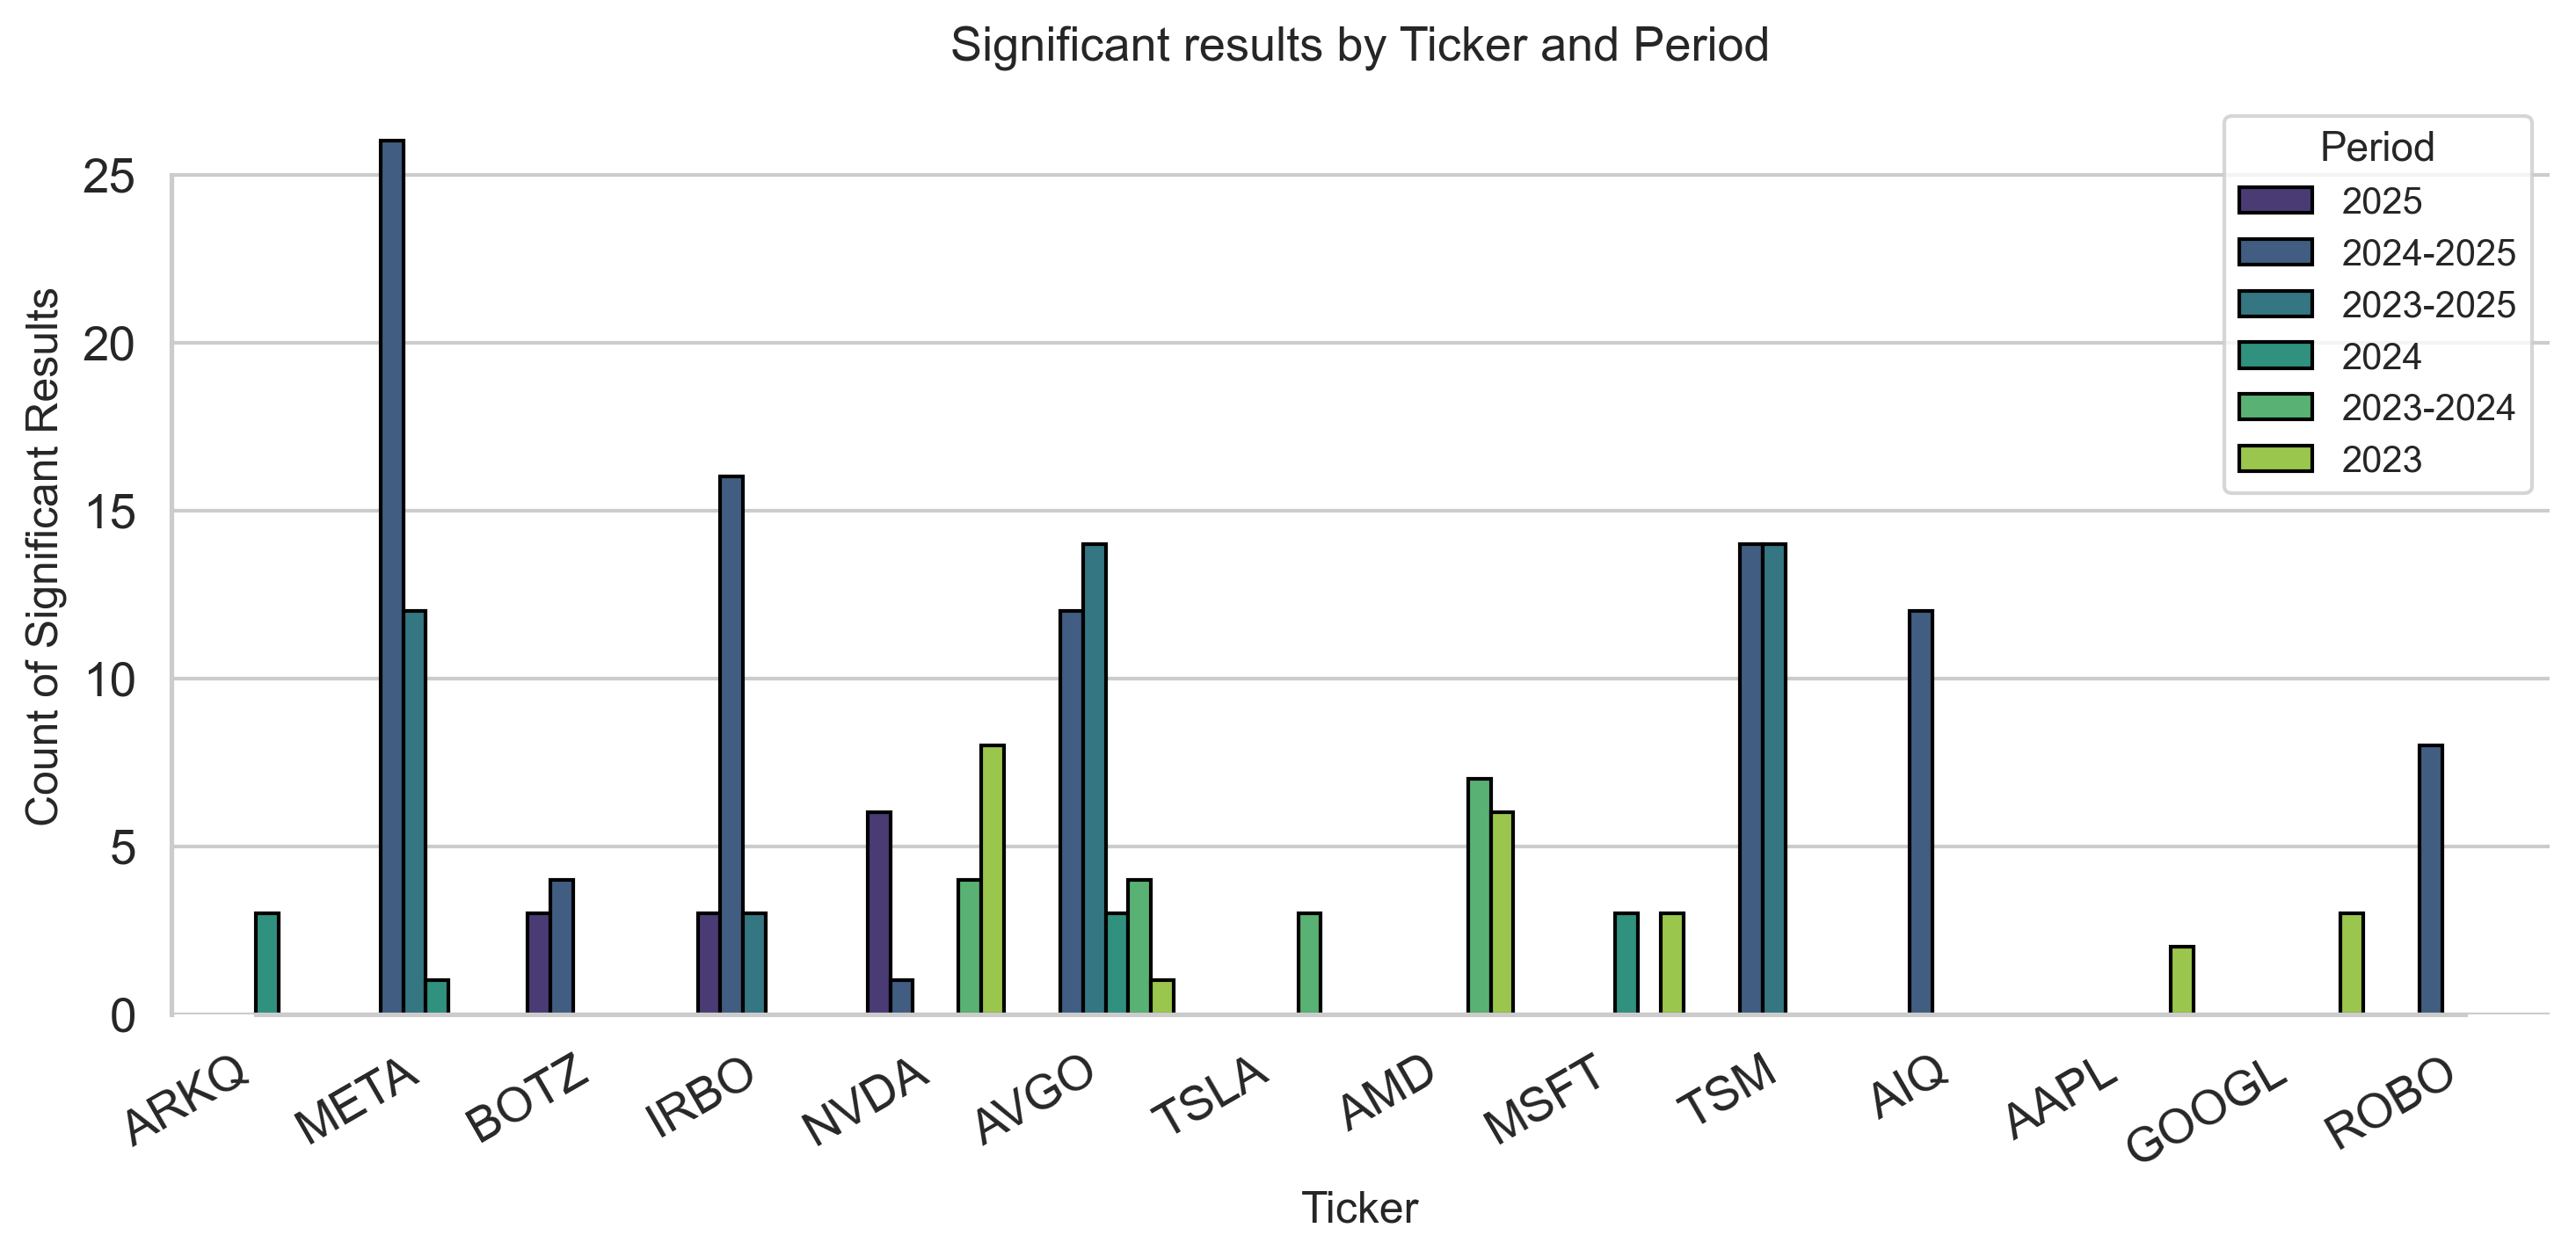

In [133]:
df = sp500_aini_to_ret_sig.copy()
df["Period"] = df["Period"].replace({
    "2023_24_25": "2023-2025",
    "2024_25": "2024-2025",
    "2023_24": "2023-2024"
}).astype(str)
df["Ticker"] = df["Ticker"].astype(str)

#  build order 
def period_key(p: str):
    years = list(map(int, re.findall(r"\d{4}", p)))
    if len(years) == 1:
        years = [years[0], years[0]]
    start, end = years[0], years[-1]
    return (end, start) 

periods = sorted(df["Period"].unique(), key=period_key, reverse=True)
df["Period"] = pd.Categorical(df["Period"], categories=periods, ordered=True)

# plot 
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 5), dpi=300)

ax = sns.countplot(
    data=df,
    x="Ticker",
    hue="Period",
    hue_order=periods,                          # <<< THIS was missing
    palette=sns.color_palette("viridis", n_colors=len(periods)),
    edgecolor="black"
)

ax.set_title("Significant results by Ticker and Period", fontsize=13, pad=10)
ax.set_xlabel("Ticker", fontsize=12)
ax.set_ylabel("Count of Significant Results", fontsize=12)
ax.legend(title="Period", title_fontsize=11, fontsize=10, loc="upper right", frameon=True)

plt.xticks(rotation=30, ha="right")
sns.despine(trim=True)
plt.tight_layout()
plt.savefig(root_dir / "reports/figures/sp500_aini_to_ret_sig_counts.png", dpi=600, bbox_inches="tight")
plt.show()


In [134]:
# group by model
model_group_tickers = (
    sp500_aini_to_ret_sig
    .groupby(["Model"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

    Model  jointly rejected at α=0.1
3      w2                         85
2      w1                         66
1      w0                         28
0  custom                         20


In [135]:
# group by model all
model_group_tickers = (
    sp500_aini_to_ret
    .groupby(["Model"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

    Model  jointly rejected at α=0.1
0  custom                       1035
1      w0                        900
2      w1                        900
3      w2                        900


In [136]:
# group by period
model_group_period = (
    sp500_aini_to_ret_sig
    .groupby(["Period"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)


       Period  jointly rejected at α=0.1
4     2024_25                         93
2  2023_24_25                         43
0        2023                         23
1     2023_24                         18
5        2025                         12
3        2024                         10


In [137]:
# group by period total
model_group_period = (
    sp500_aini_to_ret
    .groupby(["Period"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)

       Period  jointly rejected at α=0.1
0        2023                        720
1     2023_24                        720
2  2023_24_25                        720
3        2024                        720
4     2024_25                        720
5        2025                        135


In [138]:
# group by Ticker
model_group_period = (
    sp500_aini_to_ret_sig
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)

   Ticker  jointly rejected at α=0.1
8    META                         39
4    AVGO                         34
13    TSM                         28
7    IRBO                         22
10   NVDA                         19
2     AMD                         13
1     AIQ                         12
11   ROBO                          8
5    BOTZ                          7
9    MSFT                          6
6   GOOGL                          3
3    ARKQ                          3
12   TSLA                          3
0    AAPL                          2


In [139]:
# group by Ticker total
model_group_period = (
    sp500_aini_to_ret
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)

   Ticker  jointly rejected at α=0.1
0    AAPL                        249
1     AIQ                        249
2     AMD                        249
3    AMZN                        249
4    ARKQ                        249
5    AVGO                        249
6    BOTZ                        249
7   GOOGL                        249
8    IRBO                        249
9    META                        249
10   MSFT                        249
11   NVDA                        249
12   ROBO                        249
13   TSLA                        249
14    TSM                        249


In [140]:
# group by period & Ticker
model_group_tickers = (
    sp500_aini_to_ret_sig
    .groupby(["Period","Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="Ticker",ascending=True)
)


# print
print(model_group_tickers)

        Period Ticker  jointly rejected at α=0.1
0         2023   AAPL                          2
18     2024_25    AIQ                         12
1         2023    AMD                          6
6      2023_24    AMD                          7
14        2024   ARKQ                          3
7      2023_24   AVGO                          4
19     2024_25   AVGO                         12
10  2023_24_25   AVGO                         14
2         2023   AVGO                          1
15        2024   AVGO                          3
26        2025   BOTZ                          3
20     2024_25   BOTZ                          4
3         2023  GOOGL                          3
21     2024_25   IRBO                         16
11  2023_24_25   IRBO                          3
27        2025   IRBO                          3
16        2024   META                          1
12  2023_24_25   META                         12
22     2024_25   META                         26
17        2024   MSF

In [141]:
# group by period & Ticker
model_group_tickers = (
    sp500_aini_to_ret
    .groupby(["Period","Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="Ticker",ascending=True)
)


# print
model_group_tickers["jointly rejected at α=0.1"]

0     48
30    48
45    48
60    48
15    48
      ..
59    48
29    48
14    48
74    48
89     9
Name: jointly rejected at α=0.1, Length: 90, dtype: int64

In [142]:
# group by variant
model_group_measure = (
    sp500_aini_to_ret_sig
    .groupby(["AINI_variant"])
    .size()
    .reset_index(name="n_variants")
    .sort_values(by="n_variants",ascending=False)
)

print(model_group_measure)

        AINI_variant  n_variants
1             EMA_08          53
2    normalized_AINI          53
3  normalized_AINI_z          53
0             EMA_02          40


In [143]:
# group by variant
model_group_measure = (
    sp500_aini_to_ret
    .groupby(["AINI_variant"])
    .size()
    .reset_index(name="n_variants")
    .sort_values(by="n_variants",ascending=False)
)

print(model_group_measure)

        AINI_variant  n_variants
1             EMA_08         945
2    normalized_AINI         945
3  normalized_AINI_z         945
0             EMA_02         900


In [144]:
# find distinctions between models
keys = ["Ticker", "Period"]  
models = ["w0", "w1", "w2", "custom"]               

common_dfs = []
left_only_dfs = []
right_only_dfs = []

for m1, m2 in combinations(models, 2):
    df1 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m1, keys].drop_duplicates()
    df2 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m2, keys].drop_duplicates()

    # intersection
    common = df1.merge(df2, on=keys, how="inner")
    if not common.empty:
        common = common.assign(Model_pair=f"{m1}&{m2}")
        common_dfs.append(common)

    # only in left / only in right
    cmp = df1.merge(df2, on=keys, how="outer", indicator=True)
    left_only  = cmp.loc[cmp["_merge"] == "left_only",  keys].assign(only=m1)
    right_only = cmp.loc[cmp["_merge"] == "right_only", keys].assign(only=m2)

    if not left_only.empty:
        left_only_dfs.append(left_only)
    if not right_only.empty:
        right_only_dfs.append(right_only)

# Concatenate
common_all = pd.concat(common_dfs, ignore_index=True) if common_dfs else pd.DataFrame(columns=keys+["Model_pair"])
left_only_all = pd.concat(left_only_dfs, ignore_index=True) if left_only_dfs else pd.DataFrame(columns=keys+["only"])
right_only_all = pd.concat(right_only_dfs, ignore_index=True) if right_only_dfs else pd.DataFrame(columns=keys+["only"])

right_only_all

,Ticker,Period,only
0,AIQ,2024_25,w1
1,AMD,2023,w1
2,AMD,2023_24,w1
3,AVGO,2024_25,w1
4,IRBO,2023_24_25,w1
5,IRBO,2024_25,w1
6,META,2023_24_25,w1
7,MSFT,2024,w1
8,TSM,2023_24_25,w1
9,TSM,2024_25,w1


In [145]:
# find distinctions between models
keys = ["Ticker", "Period","Lags"]  
models = ["w0", "w1", "w2", "custom"]               

common_dfs = []
left_only_dfs = []
right_only_dfs = []

for m1, m2 in combinations(models, 2):
    df1 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m1, keys].drop_duplicates()
    df2 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m2, keys].drop_duplicates()

    # intersection
    common = df1.merge(df2, on=keys, how="inner")
    if not common.empty:
        common = common.assign(Model_pair=f"{m1}&{m2}")
        common_dfs.append(common)

    # only in left / only in right
    cmp = df1.merge(df2, on=keys, how="outer", indicator=True)
    left_only  = cmp.loc[cmp["_merge"] == "left_only",  keys].assign(only=m1)
    right_only = cmp.loc[cmp["_merge"] == "right_only", keys].assign(only=m2)

    if not left_only.empty:
        left_only_dfs.append(left_only)
    if not right_only.empty:
        right_only_dfs.append(right_only)

# Concatenate
common_all = pd.concat(common_dfs, ignore_index=True) if common_dfs else pd.DataFrame(columns=keys+["Model_pair"])
left_only_all = pd.concat(left_only_dfs, ignore_index=True) if left_only_dfs else pd.DataFrame(columns=keys+["only"])
right_only_all = pd.concat(right_only_dfs, ignore_index=True) if right_only_dfs else pd.DataFrame(columns=keys+["only"])

# Ensure uniqueness per model
base = sp500_aini_to_ret_sig[["Model", *keys]].drop_duplicates()
models = sorted(base["Model"].unique())

# Build set of tuples for each model
model_sets = {
    m: set(map(tuple, base.loc[base["Model"] == m, keys].to_numpy()))
    for m in models
}

# Precompute sizes
sizes = {m: len(model_sets[m]) for m in models}

# Row-normalized intersection fractions
frac = pd.DataFrame(index=models, columns=models, dtype=float)

# pure intersection counts
counts = pd.DataFrame(index=models, columns=models, dtype=int)

# Jaccard index: |A∩B| / |A∪B|
jaccard = pd.DataFrame(index=models, columns=models, dtype=float)

for m1 in models:
    S1 = model_sets[m1]
    n1 = sizes[m1]
    for m2 in models:
        S2 = model_sets[m2]
        inter = len(S1 & S2)
        union = len(S1 | S2)
        counts.loc[m1, m2] = inter
        frac.loc[m1, m2] = inter / n1 if n1 > 0 else float("nan")
        jaccard.loc[m1, m2] = inter / union if union > 0 else float("nan")

# percentages
frac_pct = (frac * 100).round(1)

# Example: show the row-normalized fraction matrix first
print("Row-normalized intersection fraction (|A∩B| / |A|):")
print(frac.round(3))
print("\nIntersection counts:")
print(counts)
print("\nJaccard index:")
print(jaccard.round(3))


Row-normalized intersection fraction (|A∩B| / |A|):
        custom     w0     w1     w2
custom     1.0  0.000  0.000  0.000
w0         0.0  1.000  0.333  0.333
w1         0.0  0.167  1.000  0.667
w2         0.0  0.115  0.462  1.000

Intersection counts:
        custom   w0    w1    w2
custom     8.0  0.0   0.0   0.0
w0         0.0  9.0   3.0   3.0
w1         0.0  3.0  18.0  12.0
w2         0.0  3.0  12.0  26.0

Jaccard index:
        custom     w0     w1     w2
custom     1.0  0.000  0.000  0.000
w0         0.0  1.000  0.125  0.094
w1         0.0  0.125  1.000  0.375
w2         0.0  0.094  0.375  1.000


In [146]:
# Define unique combinations and models
keys = ["Ticker", "Period", "Lags"]
models = sorted(sp500_aini_to_ret_sig["Model"].unique())

# Pivot to wide format (keep all combinations)
pivot = (
    sp500_aini_to_ret_sig
    .pivot_table(index=keys, columns="Model", values="β1", dropna=False)
    .reindex(columns=models)  # ensure consistent order
)

# ensure all model columns exist even if missing entirely
for m in models:
    if m not in pivot.columns:
        pivot[m] = pd.NA

# Drop rows where all model values are NaN
pivot = pivot.dropna(how="all")

# print all
print(pivot)

Model                     custom        w0        w1        w2
Ticker Period     Lags                                        
AAPL   2023       1          NaN       NaN       NaN  0.078973
                  2          NaN       NaN       NaN  0.056579
AIQ    2024_25    2          NaN       NaN -0.078131 -0.074709
                  3          NaN       NaN       NaN -0.073011
AMD    2023       1          NaN       NaN -0.056138 -0.059319
       2023_24    1          NaN       NaN -0.020867 -0.018217
ARKQ   2024       1    -0.012924       NaN       NaN       NaN
AVGO   2023       3          NaN  0.027641       NaN       NaN
       2023_24    3          NaN  0.070165       NaN       NaN
       2023_24_25 1    -0.010619       NaN       NaN       NaN
                  2          NaN       NaN       NaN -0.011467
                  3          NaN -0.011048       NaN -0.004544
       2024       3          NaN  0.077641       NaN       NaN
       2024_25    2          NaN       NaN -0.030067 -0

In [147]:
# investigate groups by Model
model_group_model = (
    sp500_aini_to_ret_sig
    .groupby(["Model"])
    .size()
    .reset_index(name="n_variants")
    .sort_values(by="n_variants",ascending=False)
)
print(model_group_model)
sp500_aini_to_ret_sig

    Model  n_variants
3      w2          85
2      w1          66
1      w0          28
0  custom          20


,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
154,custom,EMA_08,0.012553,ARKQ,2024,1,-0.014253,NaN,NaN,0.056163,NaN,NaN,0.055061,0.038415,True
156,custom,normalized_AINI,0.012743,ARKQ,2024,1,-0.012260,NaN,NaN,0.048330,NaN,NaN,0.055061,0.038415,True
158,custom,normalized_AINI_z,0.012743,ARKQ,2024,1,-0.012260,NaN,NaN,0.002401,NaN,NaN,0.055061,0.038415,True
192,custom,EMA_02,0.029404,META,2024,1,-0.085446,NaN,NaN,-0.182949,NaN,NaN,0.051995,0.067232,True
290,custom,EMA_08,0.012651,BOTZ,2025,1,-0.132385,NaN,NaN,-0.045071,NaN,NaN,0.027197,0.020862,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8622,w2,normalized_AINI_z,0.013622,ROBO,2024_25,3,-0.047957,0.044623,-0.050474,0.001599,-0.001754,-0.000935,0.054395,0.041734,True
8632,w2,EMA_02,0.034406,TSM,2024_25,3,-0.091726,0.014721,-0.090419,0.046685,-0.500253,0.420112,0.022798,0.004825,True
8634,w2,EMA_08,0.021917,TSM,2024_25,3,-0.095107,0.011939,-0.094442,0.020650,-0.102300,0.027328,0.028697,0.009682,True
8636,w2,normalized_AINI,0.020935,TSM,2024_25,3,-0.096613,0.011079,-0.093863,0.019195,-0.076882,0.003450,0.028697,0.009682,True


In [148]:
# plot distribution of betas
# defines paths
out_path = root_dir / "reports" / "figures" / "distribution_of_betas.png"

# Config (
plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})


# b columns (exclude b0)
beta_cols = [c for c in sp500_aini_to_ret_sig.columns if c.startswith("β") and c != "β₀"]

# Ensure consistent model order
models = ["w0", "w1", "w2", "custom"]

# Symmetric x-axis centered on 0 across ALL models
all_betas = sp500_aini_to_ret_sig[beta_cols].to_numpy().astype(float).ravel()
all_betas = all_betas[~np.isnan(all_betas)]
lim = float(max(abs(all_betas.min()), abs(all_betas.max())))
xlim = (-lim, lim)

# Fixed y-limit
ymax = 23
bins = 40

# Plot
fig, axes = plt.subplots(2, 2, figsize=(7.2, 5.6), sharex=True, sharey=True)  # ~single-column friendly
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    subset = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == model, beta_cols]

    # Plot combined histograms 
    subset.plot.hist(
        bins=bins,
        range=xlim,         
        alpha=0.6,
        ax=ax,
        edgecolor="black",
        legend=True,         
    )

    # Titles / axes
    ax.set_title(f"Model: {model}")
    ax.set_xlim(xlim)
    ax.set_ylim(0, ymax)
    ax.set_ylabel("Counts")         
    ax.grid(alpha=0.25, linestyle=":", linewidth=0.8)

    # Means (β̄) per β, upper-right corner
    means = subset[beta_cols].mean().values

    # Map β-column names 
    beta_labels = []
    for j, col in enumerate(beta_cols, start=1):
        beta_labels.append(fr"$\bar{{\beta}}_{{{j}}}$={means[j-1]:.3f}")
    means_str = ", ".join(beta_labels)

    ax.text(
        0.98, 0.97, means_str,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=8.5,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
    )


# Ensure common x-label 
fig.text(0.5, 0.02, "", ha="center", fontsize=10)

# Grab labels from last axes 
handles, labels = axes[-1].get_legend_handles_labels()
for ax in axes:
    ax.legend_.remove()
fig.legend(handles, labels, title="Coefficient", loc="lower center", ncol=len(beta_cols), frameon=False)

# Tight layout 
plt.tight_layout(rect=[0.04, 0.07, 1, 0.98])

# Save
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.close(fig)

print(f"Saved: {out_path}")


Saved: c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\distribution_of_betas.png


In [149]:
# plot distribution of betas
# defines paths
out_path = root_dir / "reports" / "figures" / "distribution_of_betas.png"

# Config (
plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})


# b columns (exclude b0)
beta_cols = [c for c in sp500_aini_to_ret_sig.columns if c.startswith("β") and c != "β₀"]

# Ensure consistent model order
models = ["w0", "w1", "w2", "custom"]

# Symmetric x-axis centered on 0 across ALL models
all_betas = sp500_aini_to_ret_sig[beta_cols].to_numpy().astype(float).ravel()
all_betas = all_betas[~np.isnan(all_betas)]
lim = float(max(abs(all_betas.min()), abs(all_betas.max())))
xlim = (-lim, lim)

# Fixed y-limit
ymax = 23
bins = 40

# Plot
fig, axes = plt.subplots(2, 2, figsize=(7.2, 5.6), sharex=True, sharey=True)  # ~single-column friendly
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    subset = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == model, beta_cols]

    # Plot combined histograms 
    subset.plot.hist(
        bins=bins,
        range=xlim,         
        alpha=0.6,
        ax=ax,
        edgecolor="black",
        legend=True,         
    )

    # Titles / axes
    ax.set_title(f"Model: {model}")
    ax.set_xlim(xlim)
    ax.set_ylim(0, ymax)
    ax.set_ylabel("Counts")         
    ax.grid(alpha=0.25, linestyle=":", linewidth=0.8)

    # Means (β̄) per β, upper-right corner
    means = subset[beta_cols].mean().values

    # Map β-column names 
    beta_labels = []
    for j, col in enumerate(beta_cols, start=1):
        beta_labels.append(fr"$\bar{{\beta}}_{{{j}}}$={means[j-1]:.3f}")
    means_str = ", ".join(beta_labels)

    ax.text(
        0.98, 0.97, means_str,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=8.5,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
    )


# Ensure common x-label 
fig.text(0.5, 0.02, "", ha="center", fontsize=10)

# Grab labels from last axes 
handles, labels = axes[-1].get_legend_handles_labels()
for ax in axes:
    ax.legend_.remove()
fig.legend(handles, labels, title="Coefficient", loc="lower center", ncol=len(beta_cols), frameon=False)

# Tight layout 
plt.tight_layout(rect=[0.04, 0.07, 1, 0.98])

# Save
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.close(fig)

print(f"Saved: {out_path}")


Saved: c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\distribution_of_betas.png


In [150]:
# beautify
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2023_24": "2023-2024"})
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2024_25": "2024-2025"})
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2023_24_25": "2023-2025"})

In [151]:
# sort by betas
sp500_aini_to_ret_sort = sp500_aini_to_ret_sig.assign(abs_β1=lambda x: x["β1"].abs()).sort_values("abs_β1", ascending=False)
sp500_aini_to_ret_sort_cut = sp500_aini_to_ret_sort.iloc[0:20]

# beautify 
sp500_aini_to_ret_sort_cut

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1),abs_β1
1774,custom,normalized_AINI_z,0.077312,NVDA,2025,3,-0.244612,0.122721,-0.065908,-0.010938,-0.000555,0.005241,0.065193,0.007620,True,0.244612
1772,custom,normalized_AINI,0.077312,NVDA,2025,3,-0.244612,0.122721,-0.065908,-0.136617,-0.006928,0.065457,0.065193,0.007620,True,0.244612
1770,custom,EMA_08,0.071838,NVDA,2025,3,-0.238516,0.119211,-0.079502,-0.162650,0.026939,0.051816,0.065193,0.007620,True,0.238516
334,custom,normalized_AINI_z,0.058185,NVDA,2025,1,-0.237026,NaN,NaN,-0.008961,NaN,NaN,0.025197,0.006792,True,0.237026
332,custom,normalized_AINI,0.058185,NVDA,2025,1,-0.237026,NaN,NaN,-0.111922,NaN,NaN,0.025197,0.006792,True,0.237026
330,custom,EMA_08,0.057070,NVDA,2025,1,-0.233115,NaN,NaN,-0.121602,NaN,NaN,0.025197,0.006601,True,0.233115
310,custom,normalized_AINI_z,0.026268,IRBO,2025,1,-0.177944,NaN,NaN,-0.004342,NaN,NaN,0.079325,0.065091,True,0.177944
308,custom,normalized_AINI,0.026268,IRBO,2025,1,-0.177944,NaN,NaN,-0.054224,NaN,NaN,0.079325,0.065091,True,0.177944
306,custom,EMA_08,0.026336,IRBO,2025,1,-0.174863,NaN,NaN,-0.059762,NaN,NaN,0.079325,0.065091,True,0.174863
294,custom,normalized_AINI_z,0.011104,BOTZ,2025,1,-0.133469,NaN,NaN,-0.003158,NaN,NaN,0.027197,0.020862,True,0.133469


In [161]:
# std in NVIDA stock in 2025
nvid = pd.read_csv(root_dir / "data" / "raw" / "financial" / "NVDA_full_2023_2025.csv")
nvid["Date"] = pd.to_datetime(nvid["Date"])
nvid_sub = nvid[
    (nvid["Date"] > pd.Timestamp("2024-12-31")) &
    (nvid["Date"] < pd.Timestamp("2025-06-17"))
]

std_diff = np.log(nvid_sub["Adj Close"]).diff().std()
std_diff

np.float64(0.041170823424149364)

In [ ]:
# sorted latex output
export_regression_table(
    df=sp500_aini_to_ret_sort_cut,
    title="Granger-Causality, jointly significant results (AINI $\\to$ Returns, controlled for S\\&P~500). \\textit{Source:} Own.",
    output_filename="gc_sp500_aini_to_ret_sort_beta_cut",  
    output_format="tex",
    latex_env="tabular",          
    include_caption_label=False,    
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",   
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret_sort_beta_cut.tex')

In [ ]:
export_regression_table(
    df=sp500_aini_to_ret_sort,
    title="Granger-Causality, jointly significant results (AINI → Returns, controlled for S&P 500)",
    output_filename="gc_sp500_aini_to_ret_sort_beta",
    output_format="tex",
    latex_env="longtable",         
    include_caption_label=True,    
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0,
    coef_digits=3,
    p_digits=3
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret_sort_beta.tex')

In [ ]:
export_regression_table(
    df=sp500_aini_to_ret_sort_cut,
    title="Granger-Causality, jointly significant results (AINI → Returns, controlled for S&P 500)",
    output_filename="gc_sp500_aini_to_ret_sort_beta_cut",
    output_format="tex",
    latex_env="tabular",           
    include_caption_label=False,   
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret_sort_beta_cut.tex')

Controlling for VIX

In [ ]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_log_growth_VIX_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_log_growth_VIX_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_log_growth_VIX_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_log_growth_VIX_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results_VIX = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results_VIX["joint rej. (α=0.1)"] = gc_all_results_VIX["BH_reject_F"] & gc_all_results_VIX["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results_VIX= gc_all_results_VIX.rename(columns=rename_map)
gc_all_results_VIX

gc_all_results_VIX_for_report = gc_all_results_VIX.copy()

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_VIX_for_report = gc_all_results_VIX_for_report[(gc_all_results_VIX_for_report["Model"] == "custom") | (gc_all_results_VIX_for_report["Period"] != "2025")]
gc_all_results_VIX_for_report  = gc_all_results_VIX_for_report[~((gc_all_results_VIX_for_report["AINI_variant"] == "EMA_02") & (gc_all_results_VIX_for_report["Period"] == "2025"))]

print(len(gc_all_results_VIX_for_report) / 2)

3735.0


In [ ]:
# subset by direction
vix_aini_to_ret = gc_all_results_VIX_for_report[gc_all_results_VIX_for_report["Direction"] == "AINI_to_RET"]
vix_ret_to_aini = gc_all_results_VIX_for_report[gc_all_results_VIX_for_report["Direction"] == "RET_to_AINI"]

# cols to keep
keep_a2r = [
    "Model", "AINI_variant", "Ticker", "Period", "Lags", "β₀",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

keep_r2a = [
    "Model", "AINI_variant", "Ticker", "Period", "Lags", "β₀",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

# subset
vix_aini_to_ret_sub = vix_aini_to_ret[keep_a2r]
vix_ret_to_aini_sub = vix_ret_to_aini[keep_r2a]
vix_ret_to_aini_sub

,Model,AINI_variant,Ticker,Period,Lags,β₀,β1,β1,β2,β2,...,β3,γ1,γ1,γ2,γ2,γ3,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
1,custom,EMA_02,AAPL,2023,1,NaN,NaN,-0.087203,NaN,NaN,...,NaN,NaN,0.761801,NaN,NaN,NaN,NaN,0.499150,0.479960,False
3,custom,EMA_08,AAPL,2023,1,NaN,NaN,-0.361555,NaN,NaN,...,NaN,NaN,0.241965,NaN,NaN,NaN,NaN,0.499150,0.479960,False
5,custom,normalized_AINI,AAPL,2023,1,NaN,NaN,-0.427160,NaN,NaN,...,NaN,NaN,0.090171,NaN,NaN,NaN,NaN,0.499150,0.479960,False
7,custom,normalized_AINI_z,AAPL,2023,1,NaN,NaN,-5.376787,NaN,NaN,...,NaN,NaN,0.090171,NaN,NaN,NaN,NaN,0.499150,0.479960,False
9,custom,EMA_02,AIQ,2023,1,NaN,NaN,0.118964,NaN,NaN,...,NaN,NaN,0.766042,NaN,NaN,NaN,NaN,0.847715,0.841159,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8631,w2,normalized_AINI_z,TSLA,2024_25,3,NaN,NaN,-0.760302,NaN,-1.280386,...,1.037670,NaN,0.213464,NaN,0.226110,NaN,0.130603,0.598540,0.527652,False
8633,w2,EMA_02,TSM,2024_25,3,NaN,NaN,0.017076,NaN,-0.003025,...,0.006249,NaN,0.864342,NaN,0.012425,NaN,0.052036,0.881512,0.845113,False
8635,w2,EMA_08,TSM,2024_25,3,NaN,NaN,0.040617,NaN,-0.087888,...,-0.023075,NaN,0.348606,NaN,0.174506,NaN,0.143414,0.881512,0.845113,False
8637,w2,normalized_AINI,TSM,2024_25,3,NaN,NaN,0.035925,NaN,-0.127019,...,-0.044359,NaN,0.210758,NaN,0.226635,NaN,0.134114,0.881512,0.845113,False


In [ ]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].astype(str)
vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].astype(str)

# Total number of models tested
total = vix_aini_to_ret_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = vix_aini_to_ret_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 3735
Both-method rejections: 210
Rejection rate: 5.62%


C:\Users\PC\AppData\Local\Temp\ipykernel_17380\3273238197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_17380\3273238197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].astype(str)


Investigate assets

In [ ]:
# beautify
vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].replace({"TSM": "TSMC"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24": "2023-2024"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2024_25": "2024-2025"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24_25": "2023-2025"})


C:\Users\PC\AppData\Local\Temp\ipykernel_17380\1777772733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].replace({"TSM": "TSMC"})
C:\Users\PC\AppData\Local\Temp\ipykernel_17380\1777772733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24": "2023-2024"})
C:\Users\PC\AppData\Local\Temp\ipykernel_17380\1777772733.py:4: SettingWithCopyWarning: 
A value is trying to

In [ ]:
# save merged results
gc_all_results_VIX.to_csv(var_path / "granger_causality_VIX.csv", index=False)

# define table path
table_path = root_dir / "reports" / "tables"

# Export as HTML for online appendix
gc_all_results.to_html(table_path / "granger_causality_VIX.html", index=False)

Controlled for VIX

Investigate results